In [105]:
import re
from operator import index

import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

In [106]:
data = pd.read_csv('../data/labeled_post.csv', index_col='id')

In [107]:
data['market_viability'] = data['market_viability'].map({'Viable': 1, 'Not Viable': 0})
data['post_day'] = data['post_day'].map({'monday': 0, 'tuesday': 1, 'wednesday': 2, 'thursday': 3, 'friday': 4, 'saturday': 5, 'sunday': 7})
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 498 entries, 0 to 497
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  498 non-null    object 
 1   body                   498 non-null    object 
 2   subreddit              498 non-null    object 
 3   url                    498 non-null    object 
 4   score                  498 non-null    int64  
 5   num_comments           498 non-null    int64  
 6   upvote_ratio           498 non-null    float64
 7   created_utc            498 non-null    float64
 8   author                 498 non-null    object 
 9   is_original_content    498 non-null    bool   
 10  edited                 498 non-null    bool   
 11  total_awards_received  498 non-null    int64  
 12  gilded                 498 non-null    int64  
 13  search_query           498 non-null    object 
 14  title_length           498 non-null    int64  
 15  body_length

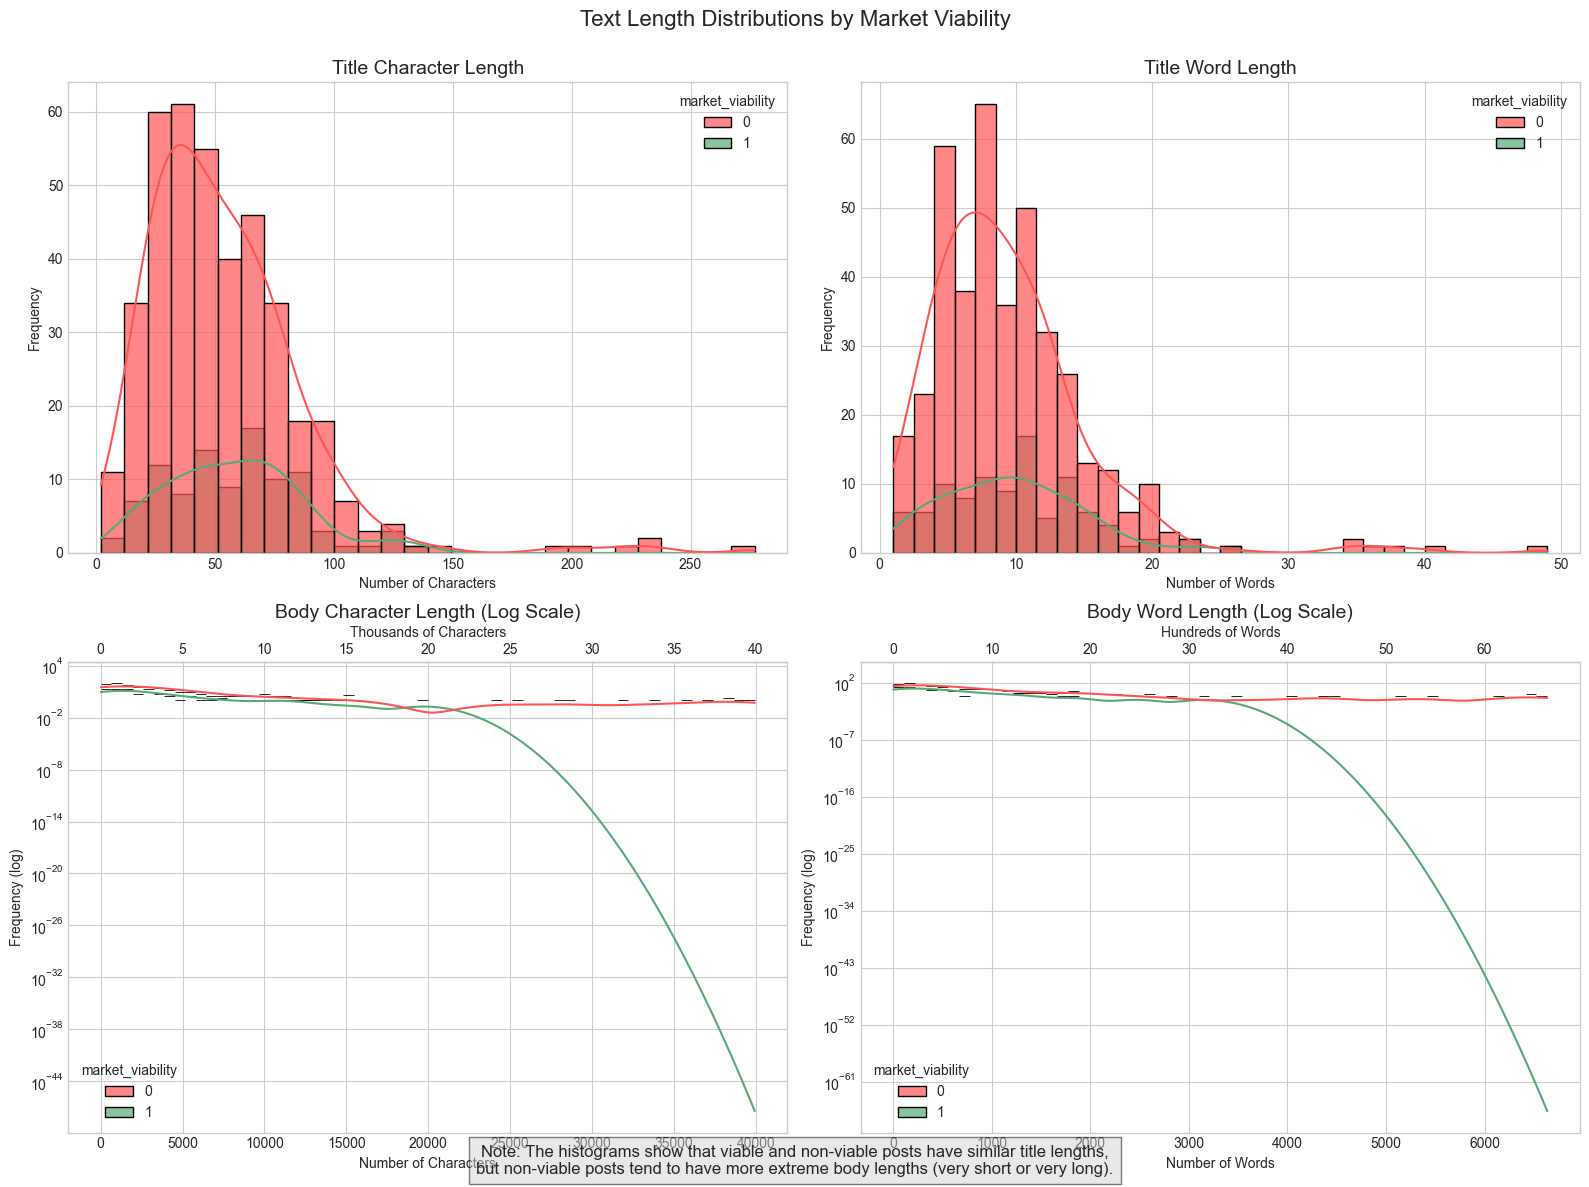

In [108]:
# Histograms of Text Length Metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up a clean, modern style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

# Create a figure with multiple subplots for different text metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Text Length Distributions by Market Viability', fontsize=16, y=0.98)

# 1. Title Character Length Histogram
sns.histplot(
    data=data,
    x='title_length',
    hue='market_viability',
    multiple='layer',
    palette=['#FF5555', '#55AA77'],
    alpha=0.7,
    kde=True,
    ax=axes[0, 0]
)
axes[0, 0].set_title('Title Character Length', fontsize=14)
axes[0, 0].set_xlabel('Number of Characters')
axes[0, 0].set_ylabel('Frequency')

# 2. Title Word Length Histogram
sns.histplot(
    data=data,
    x='title_word_count',
    hue='market_viability',
    multiple='layer',
    palette=['#FF5555', '#55AA77'],
    alpha=0.7,
    kde=True,
    ax=axes[0, 1]
)
axes[0, 1].set_title('Title Word Length', fontsize=14)
axes[0, 1].set_xlabel('Number of Words')
axes[0, 1].set_ylabel('Frequency')

# 3. Body Character Length Histogram (with log scale)
sns.histplot(
    data=data,
    x='body_length',
    hue='market_viability',
    multiple='layer',
    palette=['#FF5555', '#55AA77'],
    alpha=0.7,
    kde=True,
    log_scale=(False, True),  # Log scale on y-axis for better visualization
    ax=axes[1, 0]
)
axes[1, 0].set_title('Body Character Length (Log Scale)', fontsize=14)
axes[1, 0].set_xlabel('Number of Characters')
axes[1, 0].set_ylabel('Frequency (log)')

# Add a second x-axis with value ranges in more readable units (thousands)
secax = axes[1, 0].secondary_xaxis('top', functions=(lambda x: x/1000, lambda x: x*1000))
secax.set_xlabel('Thousands of Characters')

# 4. Body Word Length Histogram (with log scale)
sns.histplot(
    data=data,
    x='body_word_count',
    hue='market_viability',
    multiple='layer',
    palette=['#FF5555', '#55AA77'],
    alpha=0.7,
    kde=True,
    log_scale=(False, True),  # Log scale on y-axis
    ax=axes[1, 1]
)
axes[1, 1].set_title('Body Word Length (Log Scale)', fontsize=14)
axes[1, 1].set_xlabel('Number of Words')
axes[1, 1].set_ylabel('Frequency (log)')

# Add a second x-axis with value ranges in more readable units (hundreds)
secax2 = axes[1, 1].secondary_xaxis('top', functions=(lambda x: x/100, lambda x: x*100))
secax2.set_xlabel('Hundreds of Words')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.92)

# Add explanation text
plt.figtext(0.5, 0.01,
           "Note: The histograms show that viable and non-viable posts have similar title lengths,\n"
           "but non-viable posts tend to have more extreme body lengths (very short or very long).",
           ha="center", fontsize=12, bbox={"facecolor":"lightgrey", "alpha":0.5, "pad":5})

plt.show()

# Optional: Save the figure
# plt.savefig('../visualizations/text_length_histograms.png', dpi=300, bbox_inches='tight')

In [109]:
def clean_for_features(text):
    if not isinstance(text, str) or text is None or pd.isna(text):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Replace URLs with placeholder
    text = re.sub(r'https?://\S+|www\.\S+', '[URL]', text)

    # Remove Reddit username mentions
    text = re.sub(r'u/\w+', '[USER]', text)

    # Remove Reddit subreddit references
    text = re.sub(r'r/\w+', '[SUBREDDIT]', text)

    # Replace HTML entities
    text = text.replace('&amp;', '&').replace('&lt;', '<').replace('&gt;', '>')

    # Remove Reddit markdown
    text = re.sub(r'\*\*|\*|~~|__|_|\[|\]|\(|\)|\^', ' ', text)

    # Remove special characters except punctuation needed for sentiment
    text = re.sub(r'[^a-zA-Z0-9\s\.,!?:;]', '', text)

    # Fix multiple newlines and spaces
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s{2,}', ' ', text)

    # Trim whitespace
    text = text.strip()

    return text

In [110]:
data['title_features'] = data['title'].apply(clean_for_features)
data['body_features'] = data['body'].apply(clean_for_features)

In [111]:
def clean_for_bert(text):
    if not isinstance(text, str) or text is None or pd.isna(text):
        return ""

    # Replace URLs with placeholder
    text = re.sub(r'https?://\S+|www\.\S+', '[URL]', text)

    # Remove Reddit username mentions
    text = re.sub(r'u/\w+', '[USER]', text)

    # Remove Reddit subreddit references
    text = re.sub(r'r/\w+', '[SUBREDDIT]', text)

    # Replace HTML entities
    text = text.replace('&amp;', '&').replace('&lt;', '<').replace('&gt;', '>')

    # Remove Reddit markdown for bold, italic, etc.
    text = re.sub(r'\*\*|\*|~~|__|_|\[|\]|\(|\)|\^', ' ', text)

    # Fix multiple newlines (preserving paragraph structure)
    text = re.sub(r'\n{3,}', '\n\n', text)

    # Fix multiple spaces
    text = re.sub(r'\s{2,}', ' ', text)

    # Trim whitespace
    text = text.strip()

    return text

In [112]:
data['title'] = data['title'].apply(clean_for_bert)
data['body'] = data['body'].apply(clean_for_bert)

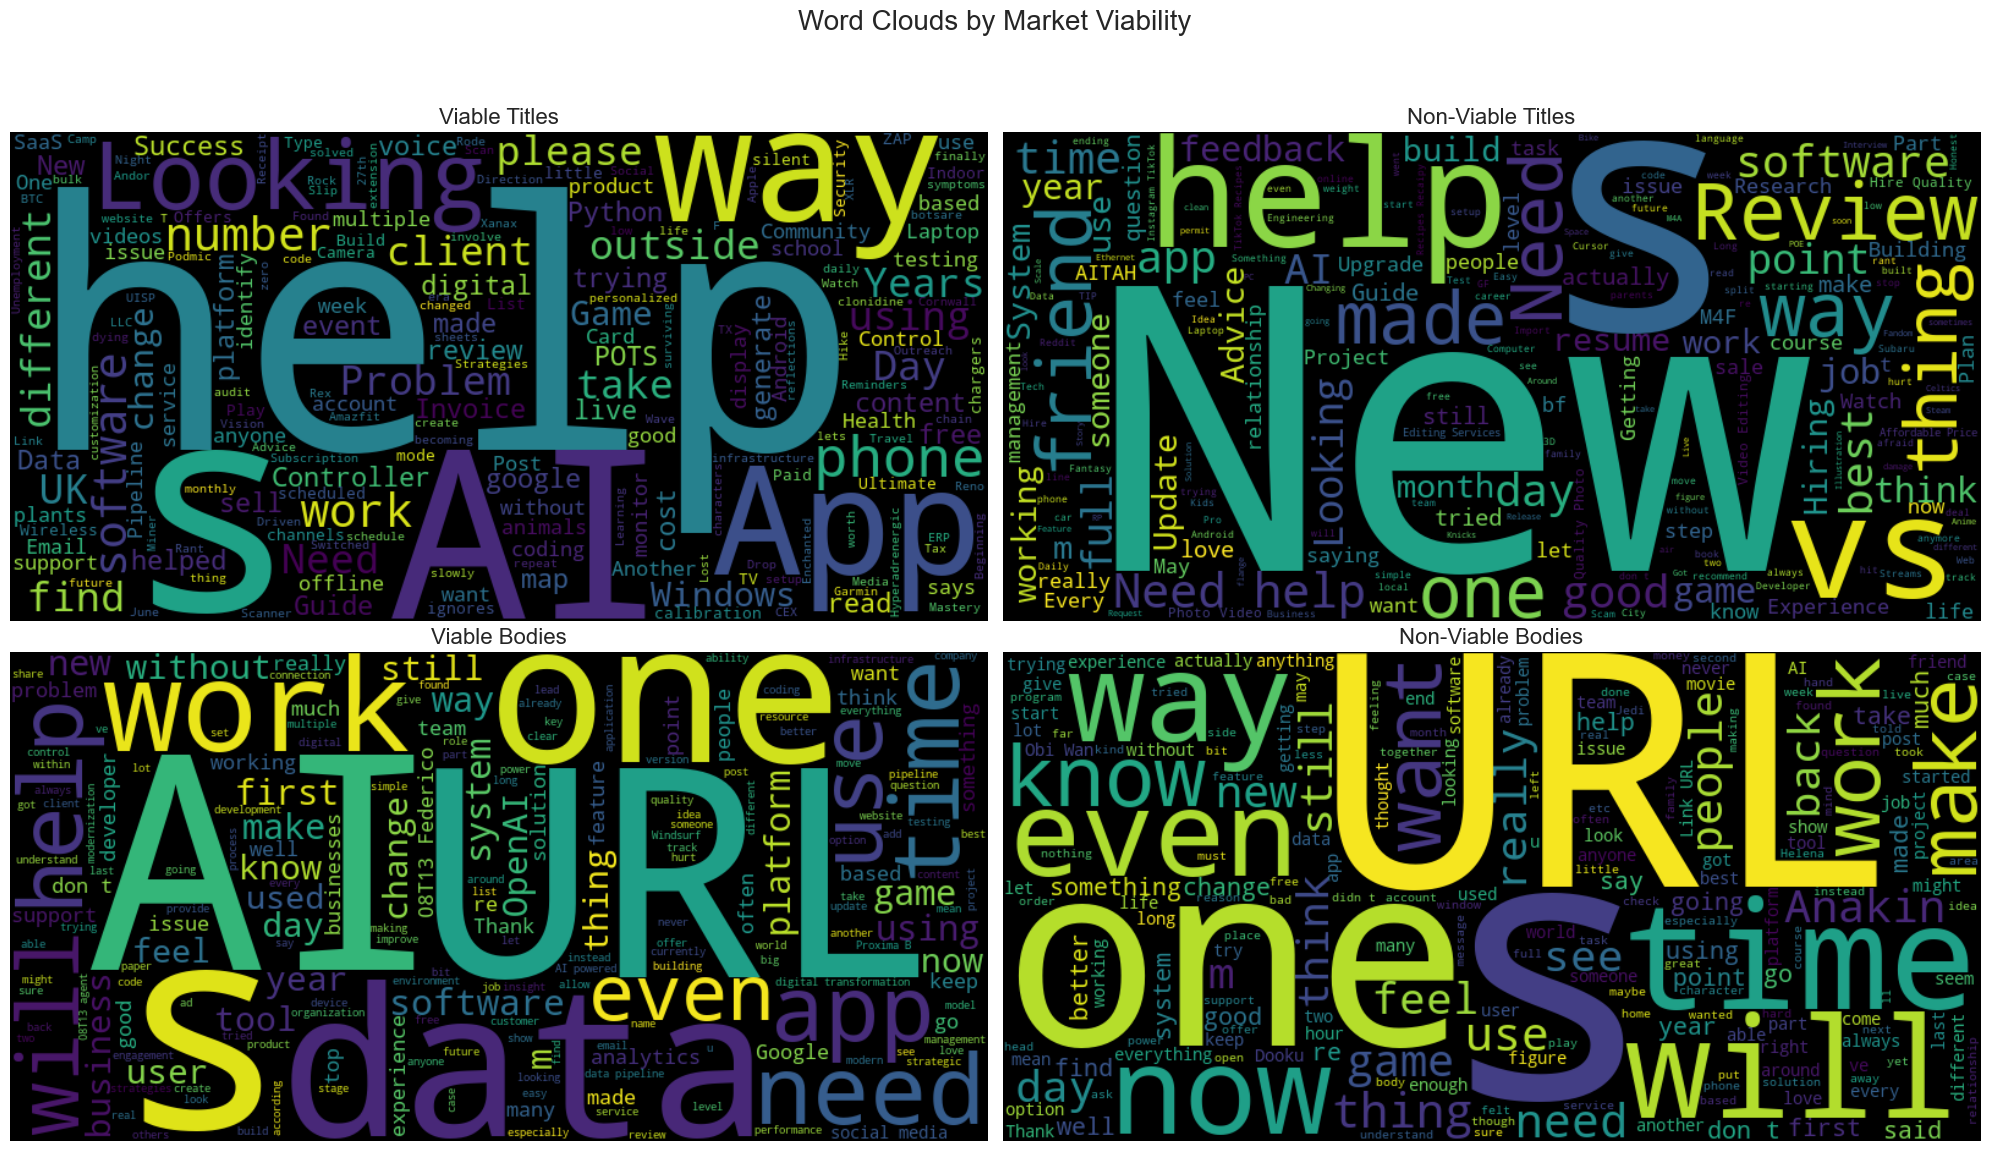

In [113]:
viable_titles = data[data['market_viability'] == 1]['title'].dropna().str.cat(sep=' ')
non_viable_titles = data[data['market_viability'] == 0]['title'].dropna().str.cat(sep=' ')
viable_bodies = data[data['market_viability'] == 1]['body'].dropna().str.cat(sep=' ')
non_viable_bodies = data[data['market_viability'] == 0]['body'].dropna().str.cat(sep=' ')

# Define a helper function
def generate_wordcloud(text, title, ax):
    wordcloud = WordCloud(width=800, height=400, background_color='black',
                          colormap='viridis', max_words=200).generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, fontsize=16)
    ax.axis('off')

# Create a 2x2 grid of word clouds
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle("Word Clouds by Market Viability", fontsize=20)

generate_wordcloud(viable_titles, "Viable Titles", axes[0, 0])
generate_wordcloud(non_viable_titles, "Non-Viable Titles", axes[0, 1])
generate_wordcloud(viable_bodies, "Viable Bodies", axes[1, 0])
generate_wordcloud(non_viable_bodies, "Non-Viable Bodies", axes[1, 1])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [114]:
analyzer = SentimentIntensityAnalyzer()

def get_vader_compound_score(text):
    return analyzer.polarity_scores(text)['compound']

data['title_sentiment'] = data['title_features'].apply(get_vader_compound_score)
data['body_sentiment'] = data['body_features'].apply(get_vader_compound_score)

In [115]:
data.drop(['url', 'subreddit', 'is_original_content', 'author', 'edited', 'gilded', 'query_category', 'time_to_mvp', 'business_model', 'has_been_labeled', 'created_datetime', 'search_query', 'title_features', 'body_features'], inplace=True, axis=1)

In [120]:
data.to_csv('../data/labeled_cleaned_data.csv', index=False)